In [ ]:
# Step 1: Install necessary libraries for QLoRA
!pip install -q bitsandbytes accelerate peft transformers datasets

# Install the evaluate library
#!pip install -q evaluate rouge_score bleu bert_score meteor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 40.3 MB/s eta 0:00:00


In [ ]:
# Step 2: Load and Preprocess Dataset

from google.colab import drive
from datasets import Dataset, DatasetDict
import json
import os
from IPython.display import display, Markdown # Import Markdown

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define paths
data_dir = "/content/drive/MyDrive/Master Thesis/Datasets/Merged_Datasets/"
train_file = os.path.join(data_dir, "merged_train.jsonl")
val_file = os.path.join(data_dir, "merged_validation.jsonl")
test_file = os.path.join(data_dir, "merged_test.jsonl")

# 3. Function to load JSONL file
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# 4. Load JSONL files manually
train_data = load_jsonl(train_file)
val_data = load_jsonl(val_file)
test_data = load_jsonl(test_file)

# 5. Create datasets from the loaded data
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

# 6. Combine into a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# 7. Format 'input' and 'output' columns into a single text block
def format_qa(example):
    return {"text": f"Question: {example['input']}\nAnswer: {example['output']}"}

dataset = dataset.map(format_qa)

# 8. Optional: Print dataset info to verify loading
print("Dataset loaded successfully!")
print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")
display(Markdown(f"\nSample formatted text:\n{dataset['train'][0]['text']}"))

Mounted at /content/drive


Map:   0%|          | 0/32418 [00:00<?, ? examples/s]

Map:   0%|          | 0/5730 [00:00<?, ? examples/s]

Map:   0%|          | 0/5689 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train samples: 32418
Validation samples: 5730
Test samples: 5689



Sample formatted text:
Question: What Does Medicare IME Stand For? 
Answer: According to the Centers for Medicare and Medicaid Services website , cms.gov , IME stands for Indirect Medical Education and is in regards to payment calculation adjustments for a Medicare discharge of higher cost patients receiving care from teaching hospitals relative to non-teaching hospitals . I would recommend contacting CMS to get more information about IME 

In [ ]:
# Step 3: Tokenize the Data_ Final code

from transformers import AutoTokenizer

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True)    #Kallal
tokenizer.pad_token = tokenizer.eos_token  # Avoid pad token issues

def tokenize(example):
    prompt = f"Question: {example['input']}\nAnswer: {example['output']}{tokenizer.eos_token}"
    tokenized_output = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokenized_output["labels"] = tokenized_output["input_ids"].copy()   # Add labels for causal language modeling
    return tokenized_output

# Apply the tokenizer to the entire dataset
tokenized_datasets = dataset.map(tokenize)
#tokenized_datasets = dataset.map(tokenize, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/32418 [00:00<?, ? examples/s]

Map:   0%|          | 0/5730 [00:00<?, ? examples/s]

Map:   0%|          | 0/5689 [00:00<?, ? examples/s]

In [ ]:
# Step 4: Zero-shot Evaluation of base GPT-2 before Fine-Tuning -- Supports multiple questions and comparison with reference answers

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# Load base GPT-2 model and tokenizer
base_model_name = "gpt2"
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_tokenizer.pad_token = base_tokenizer.eos_token  # Avoid pad token issues
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)

# Create pipeline for zero-shot inference
base_pipe = pipeline("text-generation", model=base_model, tokenizer=base_tokenizer)

# Example QA prompt from dataset
questions = [
    "What are the major coverages of a Commercial General Liability Policy?",
    "What is the coverage basis for some homeowners insurance policies?",
    "How does general liability insurance differ from professional liability insurance?",
    "What is the significance of catastrophe bonds in the insurance industry?",
]

# Parallel list of references (same order & length as questions)
references = [
    "The major coverages include bodily injury and property damage liability, personal and advertising injury liability, and medical payments coverage.",

    "Some homeowners insurance policies provide coverage on a replacement cost basis.",

    "General liability insurance covers liability arising out of acts that are not professional in nature, such as accidents on the premises, while professional liability insurance
    'covers malpractice claims.",

    "Catastrophe bonds allow insurers to protect themselves against catastrophic losses by providing a source of capital to cover these events.",

]


#########################################


# Generate answer using base GPT-2
assert len(questions) == len(references), "questions and references must have the same length."

display(Markdown("## 🔹 Zero-shot Inference (Base GPT-2) with References"))

for i, (q, ref) in enumerate(zip(questions, references), start=1):
    prompt = f"Question: {q}\nAnswer:"
    out = base_pipe(prompt, max_new_tokens=100, do_sample=False)  # deterministic for cleaner comparisons
    generated = out[0]["generated_text"]                          # shows the full completion (incl. prompt)

    # Optional: show only the part after "Answer:" for cleaner view
    ans_only = generated.split("Answer:", 1)[-1].strip() if "Answer:" in generated else generated.strip()

    display(Markdown(f"**Q{i}. {q}**"))
    display(Markdown(f"**Model (zero-shot):**\n\n> {ans_only}"))
    display(Markdown(f"**Reference:**\n\n> {ref}"))
    display(Markdown("---"))

Device set to use cuda:0


## 🔹 Zero-shot Inference (Base GPT-2) with References

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


**Q1. What are the major coverages of a Commercial General Liability Policy?**

**Model (zero-shot):**

> The Commercial General Liability Policy (CGI) is a policy that governs the conduct of commercial enterprises. It is a policy that governs the conduct of commercial enterprises in the United States. It is a policy that governs the conduct of commercial enterprises in the United States in the areas of financial services, insurance, and other business activities. It is a policy that governs the conduct of commercial enterprises in the United States in the areas of financial services, insurance, and other business activities in the United States.

**Reference:**

> The major coverages include bodily injury and property damage liability, personal and advertising injury liability, and medical payments coverage.

---

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


**Q2. What is the coverage basis for some homeowners insurance policies?**

**Model (zero-shot):**

> The coverage basis for some homeowners insurance policies is based on the amount of coverage that a homeowner has. The amount of coverage that a homeowner has is based on the amount of coverage that a homeowner has for a specific type of home.
The amount of coverage that a homeowner has for a specific type of home is based on the amount of coverage that a homeowner has for a specific type of home.
The amount of coverage that a homeowner has for a specific type of home is based on the amount of

**Reference:**

> Some homeowners insurance policies provide coverage on a replacement cost basis.

---

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


**Q3. How does general liability insurance differ from professional liability insurance?**

**Model (zero-shot):**

> General liability insurance is a type of insurance that covers a wide range of injuries and illnesses. It covers a wide range of injuries and illnesses, including:

Head injuries

Head injuries caused by a head injury

Head injuries caused by a head injury caused by a head injury

Head injuries caused by a head injury caused by a head injury

Head injuries caused by a head injury caused by a head injury

Head injuries caused by a head injury caused by a head injury

**Reference:**

> General liability insurance covers liability arising out of acts that are not professional in nature, such as accidents on the premises, while professional liability insurance covers malpractice claims.

---

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


**Q4. What is the significance of catastrophe bonds in the insurance industry?**

**Model (zero-shot):**

> The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry. The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry.
The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry. The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry

**Reference:**

> Catastrophe bonds allow insurers to protect themselves against catastrophic losses by providing a source of capital to cover these events.

---

In [ ]:
# Step 5: Evaluating the responses to the questions before fine-tuning using evaluation metrics

# Install the evaluate library
!pip install -q evaluate rouge_score bleu bert_score meteor

# === Load metrics once ===
import evaluate
import re
import pandas as pd
import numpy as np # Import numpy

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")
perplexity = evaluate.load("perplexity")

def token_overlap_scores(pred: str, ref: str):
    """Simple token-overlap precision/recall/F1 on unique word tokens."""
    p_tokens = re.findall(r"\w+", pred.lower())
    r_tokens = re.findall(r"\w+", ref.lower())
    p_set, r_set = set(p_tokens), set(r_tokens)
    inter = len(p_set & r_set)
    prec = inter / (len(p_set) or 1)
    rec  = inter / (len(r_set) or 1)
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else 0.0
    return prec, rec, f1

rows = []
preds, refs = [], []

# Assuming 'questions' and 'references' lists are available from the previous cell (QNaBcZkf9Kw0)
# and 'base_pipe' and 'tokenizer' are also available.

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# Load base GPT-2 model and tokenizer (ensure these are loaded if not already)
base_model_name = "gpt2"
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_tokenizer.pad_token = base_tokenizer.eos_token
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)

# Create pipeline for zero-shot inference (ensure this is created if not already)
base_pipe = pipeline("text-generation", model=base_model, tokenizer=base_tokenizer)


# --- per-example metrics ---
for i, (q, ref) in enumerate(zip(questions, references), start=1):
    prompt = f"Question: {q}\nAnswer:"
    out = base_pipe(prompt, max_new_tokens=100, do_sample=False)
    generated = out[0]["generated_text"]
    ans = generated.split("Answer:", 1)[-1].strip() if "Answer:" in generated else generated.strip()

    r = rouge.compute(predictions=[ans], references=[ref], use_stemmer=True)
    b = bleu.compute(predictions=[ans], references=[[ref]])["bleu"]
    try:
        m = meteor.compute(predictions=[ans], references=[ref])["meteor"]
    except Exception:
        m = None  # If METEOR backend/jar isn't available, don't fail the run

    bs = bertscore.compute(
        predictions=[ans], references=[ref],
        lang="en", model_type="microsoft/deberta-base-mnli"
    )
    bs_p, bs_r, bs_f1 = float(bs["precision"][0]), float(bs["recall"][0]), float(bs["f1"][0])

    # Perplexity requires the full text, not just the answer
    # We'll compute perplexity for the whole generated text
    try:
        ppl = perplexity.compute(predictions=[generated], model_id="gpt2")["perplexities"][0]
    except Exception as e:
        print(f"Could not compute perplexity for example {i}: {e}")
        ppl = None


    tok_p, tok_r, tok_f1 = token_overlap_scores(ans, ref)

    rows.append({
        "Q#": i,
        "Question": q,
        "Model Answer": ans,
        "Reference": ref,
        "TokenOverlap-P": tok_p,
        "TokenOverlap-R": tok_r,
        "TokenOverlap-F1": tok_f1,
        "ROUGE-1": r["rouge1"],
        "ROUGE-2": r["rouge2"],
        "ROUGE-L": r["rougeL"],
        "BLEU": b,
        "METEOR": m,
        "BERTScore-P": bs_p,
        "BERTScore-R": bs_r,
        "BERTScore-F1": bs_f1,
        "Perplexity": ppl,
    })

    # --- nice per-Q display (optional) ---
    display(Markdown(f"**Q{i}. {q}**"))
    display(Markdown(f"**Model (zero-shot):**\n\n> {ans}"))
    display(Markdown(f"**Reference:**\n\n> {ref}"))
    display(Markdown(
        f"**Metrics:** ROUGE-1: {r['rouge1']:.4f} · ROUGE-2: {r['rouge2']:.4f} · ROUGE-L: {r['rougeL']:.4f} · "
        f"BLEU: {b:.4f} · METEOR: {m if m is None else f'{m:.4f}'} · "
        f"BERTScore(P/R/F1): {bs_p:.4f}/{bs_r:.4f}/{bs_f1:.4f} · Perplexity: {ppl if ppl is None else f'{ppl:.2f}'} · "
        f"TokenOverlap(F1): {tok_f1:.4f}"
    ))
    display(Markdown("---"))

# === Tabular summary ===
df = pd.DataFrame(rows)
# Optional: order columns
cols = ["Q#", "Question", "Model Answer", "Reference",
        "TokenOverlap-P", "TokenOverlap-R", "TokenOverlap-F1",
        "ROUGE-1", "ROUGE-2", "ROUGE-L",
        "BLEU", "METEOR",
        "BERTScore-P", "BERTScore-R", "BERTScore-F1",
        "Perplexity"]
df = df[cols]
display(df)

# === Aggregate (dataset-level) summary (optional) ===
preds = [r["Model Answer"] for r in rows]
refs  = [r["Reference"] for r in rows]

agg_rouge = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
agg_bleu  = bleu.compute(predictions=preds, references=[[x] for x in refs])
try:
    agg_meteor = meteor.compute(predictions=preds, references=refs)
except Exception:
    agg_meteor = {"meteor": None}
agg_bert  = bertscore.compute(predictions=preds, references=refs, lang="en", model_type="microsoft/deberta-base-mnli")
# Aggregate perplexity requires the full generated texts
agg_generated_texts = [out[0]["generated_text"] for i, (q, ref) in enumerate(zip(questions, references), start=1) for out in [base_pipe(f"Question: {q}\nAnswer:", max_new_tokens=100, do_sample=False)]]

try:
    agg_ppl   = perplexity.compute(predictions=agg_generated_texts, model_id="gpt2")
except Exception as e:
    print(f"Could not compute aggregate perplexity: {e}")
    agg_ppl = {"mean_perplexity": None}


display(Markdown("### 📊 Aggregate metrics"))
display(Markdown(
    f"- ROUGE-1: **{agg_rouge['rouge1']:.4f}**, ROUGE-2: **{agg_rouge['rouge2']:.4f}**, ROUGE-L: **{agg_rouge['rougeL']:.4f}**\n"
    f"- BLEU: **{agg_bleu['bleu']:.4f}**\n"
    f"- METEOR: **{agg_meteor['meteor'] if agg_meteor['meteor'] is None else f'{agg_meteor['meteor']:.4f}'}**\n"
    f"- BERTScore (mean P/R/F1): **{np.mean(agg_bert['precision']):.4f} / {np.mean(agg_bert['recall']):.4f} / {np.mean(agg_bert['f1']):.4f}**\n"
    f"- Mean Perplexity: **{agg_ppl['mean_perplexity'] if agg_ppl['mean_perplexity'] is None else f'{agg_ppl['mean_perplexity']:.2f}'}**"
))

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 66.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

**Q1. What are the major coverages of a Commercial General Liability Policy?**

**Model (zero-shot):**

> The Commercial General Liability Policy (CGI) is a policy that governs the conduct of commercial enterprises. It is a policy that governs the conduct of commercial enterprises in the United States. It is a policy that governs the conduct of commercial enterprises in the United States in the areas of financial services, insurance, and other business activities. It is a policy that governs the conduct of commercial enterprises in the United States in the areas of financial services, insurance, and other business activities in the United States.

**Reference:**

> The major coverages include bodily injury and property damage liability, personal and advertising injury liability, and medical payments coverage.

**Metrics:** ROUGE-1: 0.0755 · ROUGE-2: 0.0000 · ROUGE-L: 0.0755 · BLEU: 0.0000 · METEOR: 0.1626 · BERTScore(P/R/F1): 0.4965/0.5756/0.5332 · Perplexity: 4.36 · TokenOverlap(F1): 0.1500

---

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  0%|          | 0/1 [00:00<?, ?it/s]

**Q2. What is the coverage basis for some homeowners insurance policies?**

**Model (zero-shot):**

> The coverage basis for some homeowners insurance policies is based on the amount of coverage that a homeowner has. The amount of coverage that a homeowner has is based on the amount of coverage that a homeowner has for a specific type of home.
The amount of coverage that a homeowner has for a specific type of home is based on the amount of coverage that a homeowner has for a specific type of home.
The amount of coverage that a homeowner has for a specific type of home is based on the amount of

**Reference:**

> Some homeowners insurance policies provide coverage on a replacement cost basis.

**Metrics:** ROUGE-1: 0.1509 · ROUGE-2: 0.0577 · ROUGE-L: 0.1321 · BLEU: 0.0000 · METEOR: 0.4022 · BERTScore(P/R/F1): 0.4324/0.6783/0.5282 · Perplexity: 3.06 · TokenOverlap(F1): 0.5161

---

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  0%|          | 0/1 [00:00<?, ?it/s]

**Q3. How does general liability insurance differ from professional liability insurance?**

**Model (zero-shot):**

> General liability insurance is a type of insurance that covers a wide range of injuries and illnesses. It covers a wide range of injuries and illnesses, including:

Head injuries

Head injuries caused by a head injury

Head injuries caused by a head injury caused by a head injury

Head injuries caused by a head injury caused by a head injury

Head injuries caused by a head injury caused by a head injury

Head injuries caused by a head injury caused by a head injury

**Reference:**

> General liability insurance covers liability arising out of acts that are not professional in nature, such as accidents on the premises, while professional liability insurance covers malpractice claims.

**Metrics:** ROUGE-1: 0.1429 · ROUGE-2: 0.0364 · ROUGE-L: 0.1071 · BLEU: 0.0000 · METEOR: 0.1366 · BERTScore(P/R/F1): 0.5197/0.5684/0.5430 · Perplexity: 2.95 · TokenOverlap(F1): 0.2791

---

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  0%|          | 0/1 [00:00<?, ?it/s]

**Q4. What is the significance of catastrophe bonds in the insurance industry?**

**Model (zero-shot):**

> The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry. The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry.
The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry. The risk of a catastrophe bond is that it will be sold to a person who is not a member of the insurance industry

**Reference:**

> Catastrophe bonds allow insurers to protect themselves against catastrophic losses by providing a source of capital to cover these events.

**Metrics:** ROUGE-1: 0.1379 · ROUGE-2: 0.0175 · ROUGE-L: 0.1379 · BLEU: 0.0000 · METEOR: 0.2028 · BERTScore(P/R/F1): 0.4013/0.4515/0.4249 · Perplexity: 2.85 · TokenOverlap(F1): 0.2105

---

,Q#,Question,Model Answer,Reference,TokenOverlap-P,TokenOverlap-R,TokenOverlap-F1,ROUGE-1,ROUGE-2,ROUGE-L,BLEU,METEOR,BERTScore-P,BERTScore-R,BERTScore-F1,Perplexity
0,1,What are the major coverages of a Commercial G...,The Commercial General Liability Policy (CGI) ...,The major coverages include bodily injury and ...,0.120000,0.200000,0.150000,0.075472,0.000000,0.075472,0.0,0.162574,0.496548,0.575587,0.533154,4.360920
1,2,What is the coverage basis for some homeowners...,The coverage basis for some homeowners insuran...,Some homeowners insurance policies provide cov...,0.400000,0.727273,0.516129,0.150943,0.057692,0.132075,0.0,0.402184,0.432430,0.678320,0.528158,3.064533
2,3,How does general liability insurance differ fr...,General liability insurance is a type of insur...,General liability insurance covers liability a...,0.300000,0.260870,0.279070,0.142857,0.036364,0.107143,0.0,0.136612,0.519745,0.568403,0.542986,2.949024
3,4,What is the significance of catastrophe bonds ...,The risk of a catastrophe bond is that it will...,Catastrophe bonds allow insurers to protect th...,0.210526,0.210526,0.210526,0.137931,0.017544,0.137931,0.0,0.202761,0.401272,0.451469,0.424893,2.845817


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  0%|          | 0/1 [00:00<?, ?it/s]

### 📊 Aggregate metrics

- ROUGE-1: **0.1268**, ROUGE-2: **0.0279**, ROUGE-L: **0.1140**
- BLEU: **0.0000**
- METEOR: **0.2260**
- BERTScore (mean P/R/F1): **0.4625 / 0.5684 / 0.5073**
- Mean Perplexity: **3.31**

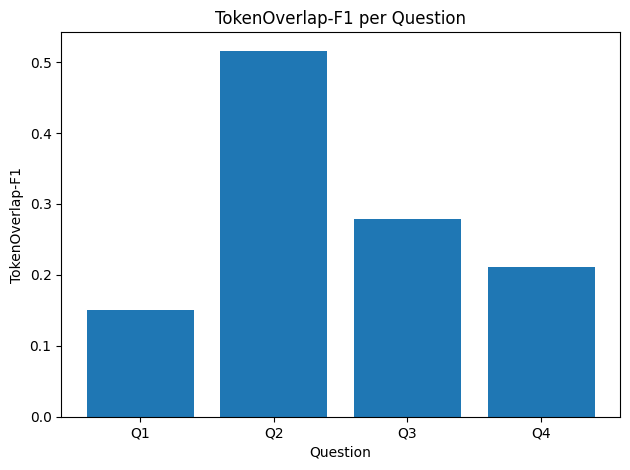

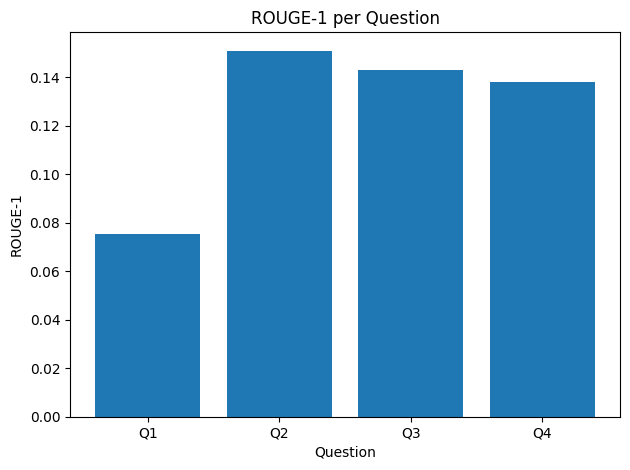

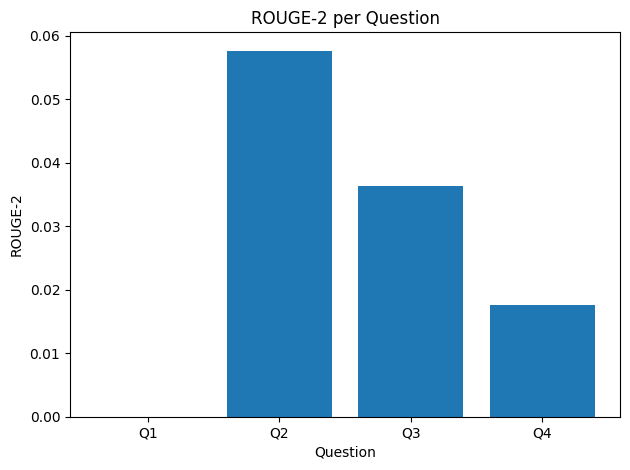

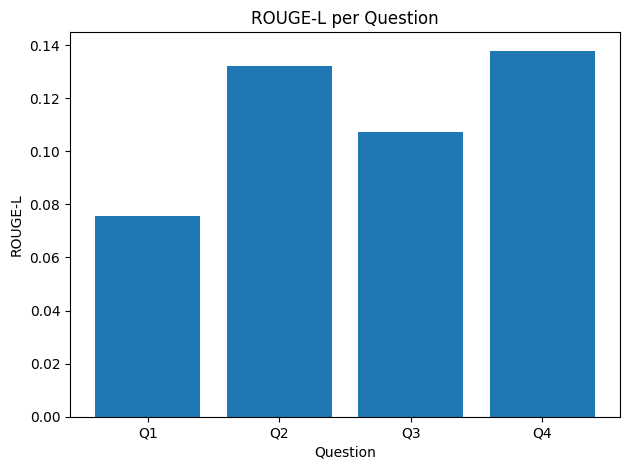

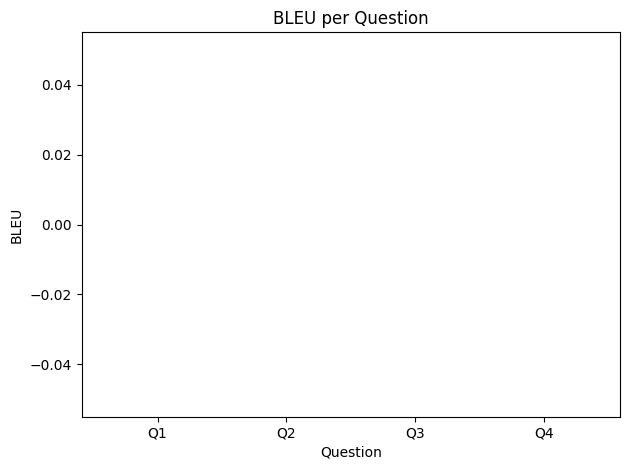

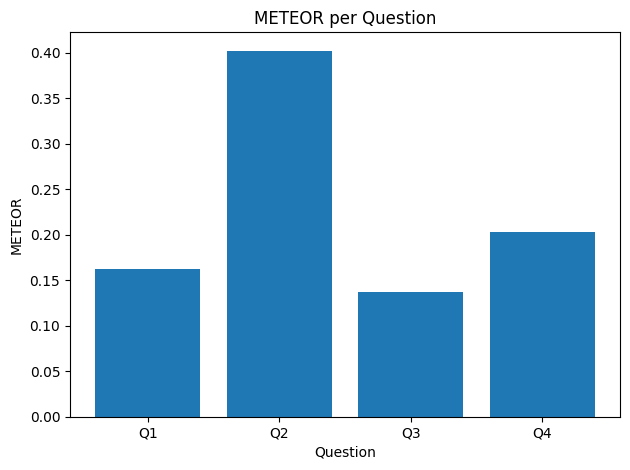

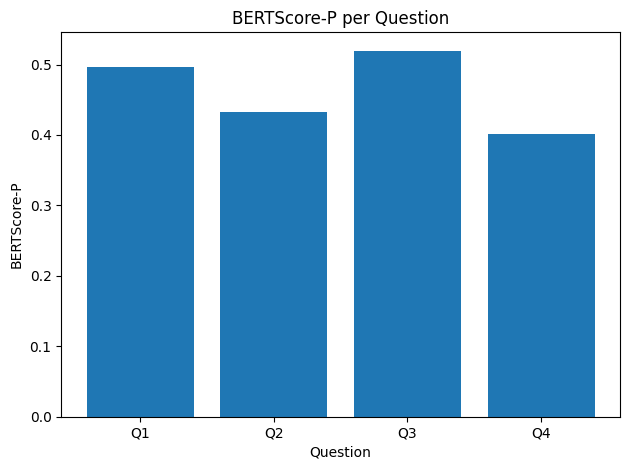

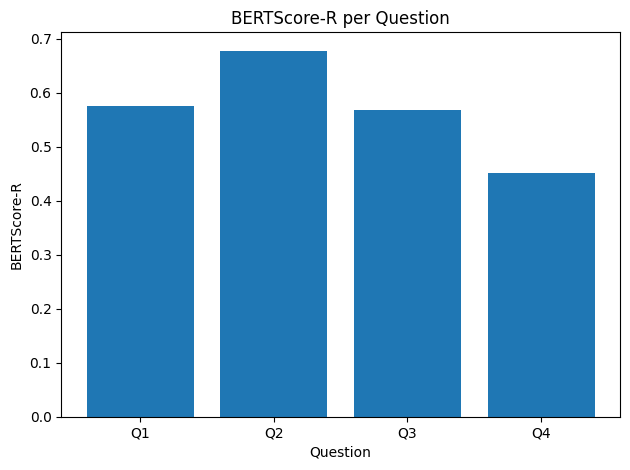

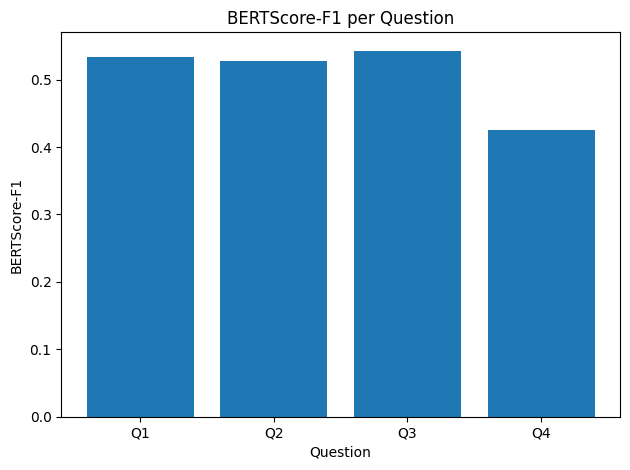

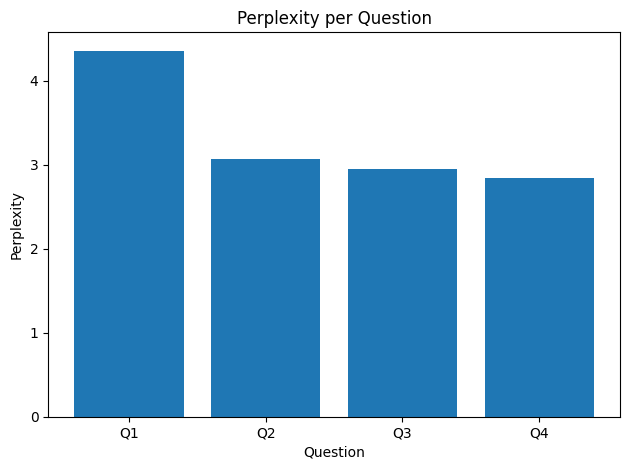

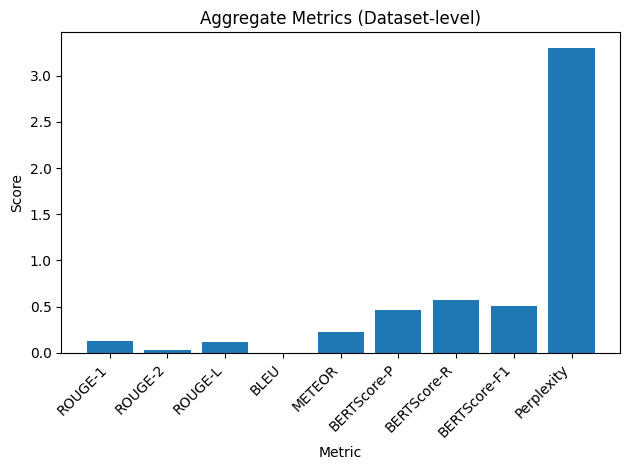

In [ ]:
#Step 6: Visualize evaluation metrics (per question + aggregate) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expect the metrics DataFrame from the previous step
assert 'df' in globals(), "Run the previous cell that builds 'df' first."

# Short x-axis labels like Q1, Q2, ...
x_labels = [f"Q{int(x)}" for x in df["Q#"]]

# List of numeric metrics to chart per-question
per_question_metrics = [
    "TokenOverlap-F1",
    "ROUGE-1", "ROUGE-2", "ROUGE-L",
    "BLEU", "METEOR",
    "BERTScore-P", "BERTScore-R", "BERTScore-F1",
    "Perplexity",
]

# --- Per-question charts (one chart per metric) ---
for metric in per_question_metrics:
    vals = pd.to_numeric(df[metric], errors="coerce").fillna(0.0).values

    plt.figure()
    plt.bar(x_labels, vals)
    plt.title(f"{metric} per Question")
    plt.xlabel("Question")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

# --- Aggregate chart (uses corpus-level if available, else falls back to per-question mean) ---
# If you ran the "Aggregate metrics" block earlier, these may exist:
#   agg_rouge, agg_bleu, agg_meteor, agg_bert, agg_ppl
# We’ll auto-detect and gracefully fall back to means from df.

def pick(key, default_mean):
    try:
        return float(key)
    except Exception:
        return float(default_mean)

agg_vals = {
    "ROUGE-1":  ( (globals().get("agg_rouge", {}) or {}).get("rouge1")
                  if "agg_rouge" in globals() else df["ROUGE-1"].mean() ),
    "ROUGE-2":  ( (globals().get("agg_rouge", {}) or {}).get("rouge2")
                  if "agg_rouge" in globals() else df["ROUGE-2"].mean() ),
    "ROUGE-L":  ( (globals().get("agg_rouge", {}) or {}).get("rougeL")
                  if "agg_rouge" in globals() else df["ROUGE-L"].mean() ),
    "BLEU":     ( (globals().get("agg_bleu",  {}) or {}).get("bleu")
                  if "agg_bleu"  in globals() else df["BLEU"].mean() ),
    "METEOR":   ( (globals().get("agg_meteor",{}) or {}).get("meteor")
                  if "agg_meteor" in globals() and (globals()["agg_meteor"].get("meteor") is not None)
                  else pd.to_numeric(df["METEOR"], errors="coerce").dropna().mean() ),
    "BERTScore-P": ( np.mean(globals().get("agg_bert", {}).get("precision", []))
                     if "agg_bert" in globals() else df["BERTScore-P"].mean() ),
    "BERTScore-R": ( np.mean(globals().get("agg_bert", {}).get("recall", []))
                     if "agg_bert" in globals() else df["BERTScore-R"].mean() ),
    "BERTScore-F1": ( np.mean(globals().get("agg_bert", {}).get("f1", []))
                      if "agg_bert" in globals() else df["BERTScore-F1"].mean() ),
    "Perplexity": ( (globals().get("agg_ppl", {}) or {}).get("mean_perplexity")
                    if "agg_ppl" in globals() else df["Perplexity"].mean() ),
}

# Plot aggregate bars
agg_names = list(agg_vals.keys())
agg_numbers = [float(x) if x is not None else np.nan for x in agg_vals.values()]
agg_numbers = [0.0 if (x is None or (isinstance(x, float) and np.isnan(x))) else x for x in agg_numbers]

plt.figure()
plt.bar(agg_names, agg_numbers)
plt.title("Aggregate Metrics (Dataset-level)")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# Step 7: Load model with 4-bit quantization using BitsAndBytes
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load GPT-2
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
    #device_map={"":0}    # Mentioned in two places
)

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
# Step 8: Apply QLoRA using PEFT
# Preparing the model for QLoRA. Here, the model is prepared for QLoRA training using the 'prepare_model_for_kbit_training()' function from PEFT. This function initializes the model for QLoRA by setting up the necessary configurations.

from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()          #Kallal
model = prepare_model_for_kbit_training(model)


In [ ]:
# Step 9: Setup PEFT for Fine-Tuning. Define LoRA configuration for Fine-tuning the base model.
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],    # Fine-tuning specific layers
    #target_modules=["c_attn", "c_fc", "c_proj"],
    #lora_dropout=0.05,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply QLoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475


In [ ]:
# Step 10: Define training arguments suitable for QLoRA
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling, EarlyStoppingCallback
import numpy as np

training_args = TrainingArguments(
    output_dir="./gpt2-qlora",
    overwrite_output_dir=True,
    eval_strategy="steps",
    logging_strategy="steps",
    save_strategy="steps",
    logging_steps=10,
    eval_steps=100,
    save_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    weight_decay=0.01,            # L2 regularization
    warmup_steps=100,
    #max_steps=10,
    fp16=True,
    gradient_checkpointing=True,  # today
    save_total_limit=1,
    logging_dir="./logs",
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    optim="paged_adamw_8bit",      #today
    metric_for_best_model="eval_loss",
)



data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Custom EarlyStopping with logging
class LoggingEarlyStoppingCallback(EarlyStoppingCallback):
    def __init__(self, early_stopping_patience=5, early_stopping_threshold=0.0, metric_for_best_model="eval_loss"):
        super().__init__(early_stopping_patience, early_stopping_threshold)
        self.patience_counter = 0
        self.best_score = None
        self.metric_for_best_model = metric_for_best_model # Initialize the attribute


    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        current_score = metrics.get(self.metric_for_best_model, None)

        if current_score is None:
            print("[EarlyStopping] No metric to monitor yet.")
            return

        # First evaluation
        if self.best_score is None:
            self.best_score = current_score
            print(f"[EarlyStopping] First eval - Best score: {self.best_score:.4f}")
            return

        # Improvement check
        if self.best_score - current_score > self.early_stopping_threshold:
            self.best_score = current_score
            self.patience_counter = 0
            print(f"[EarlyStopping] Improvement detected! New best score: {self.best_score:.4f}")
        else:
            self.patience_counter += 1
            print(f"[EarlyStopping] No improvement. Patience counter: {self.patience_counter}/{self.early_stopping_patience}")

            if self.patience_counter >= self.early_stopping_patience:
                print("[EarlyStopping] Patience limit reached. Stopping training early.")
                control.should_training_stop = True

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    callbacks=[LoggingEarlyStoppingCallback(early_stopping_patience=5, metric_for_best_model="eval_loss")]
)

/tmp/ipython-input-2880799300.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
  # Training mode switch
  USE_CV = True   # <- set to False when CV is not required
  K_FOLDS = 5
  RANDOM_STATE = 42

In [ ]:
# === Step 8.1: K-Fold Cross-Validation (optional) ===
if USE_CV:
    from sklearn.model_selection import KFold
    from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
    from peft import get_peft_model, prepare_model_for_kbit_training
    import numpy as np, os

    base_ds = tokenized_datasets["train"]
    n = len(base_ds)
    print(f"=== {K_FOLDS}-Fold CV on TRAIN (n={n}) ===")

    def init_peft_model():
        base = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map="auto"
        )
        base.gradient_checkpointing_enable()
        prepped = prepare_model_for_kbit_training(base)
        return get_peft_model(prepped, lora_config)

    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    eval_losses, outdirs = [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(range(n)), start=1):
        print(f"\n--- Fold {fold}/{K_FOLDS} ---")
        train_fold = base_ds.select(tr_idx)
        val_fold   = base_ds.select(va_idx)

        model = init_peft_model()
        outdir = f"./gpt2-qlora-fold{fold}"

        # New TrainingArguments per fold: same as above, just different output dirs & seed
        fold_args = TrainingArguments(
            output_dir=outdir,
            overwrite_output_dir=True,
            eval_strategy=training_args.eval_strategy,
            logging_strategy=training_args.logging_strategy,
            save_strategy=training_args.save_strategy,
            logging_steps=training_args.logging_steps,
            eval_steps=training_args.eval_steps,
            save_steps=training_args.save_steps,
            per_device_train_batch_size=training_args.per_device_train_batch_size,
            per_device_eval_batch_size=training_args.per_device_eval_batch_size,
            gradient_accumulation_steps=training_args.gradient_accumulation_steps,
            num_train_epochs=training_args.num_train_epochs,
            learning_rate=training_args.learning_rate,
            weight_decay=training_args.weight_decay,
            warmup_steps=training_args.warmup_steps,
            fp16=training_args.fp16,
            gradient_checkpointing=training_args.gradient_checkpointing,
            save_total_limit=training_args.save_total_limit,
            logging_dir=os.path.join(outdir, "logs"),
            push_to_hub=False,
            report_to=training_args.report_to,
            load_best_model_at_end=True,
            optim=training_args.optim,
            metric_for_best_model="eval_loss",
            seed=RANDOM_STATE + fold,
        )

        fold_trainer = Trainer(
            model=model,
            args=fold_args,
            train_dataset=train_fold,
            eval_dataset=val_fold,
            tokenizer=tokenizer,
            data_collator=data_collator,
            callbacks=[LoggingEarlyStoppingCallback(early_stopping_patience=4, metric_for_best_model="eval_loss")]
        )

        fold_trainer.train()                       # <— training happens here (per fold)
        metrics = fold_trainer.evaluate()
        evloss = float(metrics.get("eval_loss", np.nan))
        print(f"Fold {fold} eval_loss: {evloss:.4f}")

        fold_trainer.save_model(outdir)           # saves the LoRA adapter for this fold
        eval_losses.append(evloss)
        outdirs.append(outdir)

    # Pick best fold
    best_fold = int(np.nanargmin(np.array(eval_losses))) + 1
    best_model_path = outdirs[best_fold - 1]
    print("\n=== CV Summary ===")
    for i, v in enumerate(eval_losses, 1):
        print(f"Fold {i}: eval_loss = {v:.4f}")
    print(f"Best fold = {best_fold}  -> best_model_path = {best_model_path}")


=== 5-Fold CV on TRAIN (n=32418) ===

--- Fold 1/5 ---


/tmp/ipython-input-3451322349.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  fold_trainer = Trainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,3.288000,2.165797
200,3.065600,2.055280
300,3.014900,2.012261
400,2.939800,2.001942
500,3.021100,1.959589
600,2.984800,1.977372
700,2.904600,1.993496
800,2.943100,1.988341
900,2.912500,1.936132
1000,2.791200,1.925373


[EarlyStopping] First eval - Best score: 2.1658
[EarlyStopping] Improvement detected! New best score: 2.0553
[EarlyStopping] Improvement detected! New best score: 2.0123
[EarlyStopping] Improvement detected! New best score: 2.0019
[EarlyStopping] Improvement detected! New best score: 1.9596
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] No improvement. Patience counter: 3/4
[EarlyStopping] Improvement detected! New best score: 1.9361
[EarlyStopping] Improvement detected! New best score: 1.9254
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9100
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9090
[EarlyStopping] Improvement detected! New best score: 1.9085
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.8835
[EarlyStopping] No

[EarlyStopping] No improvement. Patience counter: 5/4
[EarlyStopping] Patience limit reached. Stopping training early.
Fold 1 eval_loss: 1.8835

--- Fold 2/5 ---


/tmp/ipython-input-3451322349.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  fold_trainer = Trainer(


Step,Training Loss,Validation Loss
100,3.302900,2.265995
200,3.124900,2.059768
300,3.057100,2.022811
400,3.031600,2.011275
500,3.001000,2.006011
600,2.969900,1.986203
700,2.942300,1.979089
800,2.937700,1.972645
900,2.821900,1.992323
1000,2.862200,1.943218


[EarlyStopping] First eval - Best score: 2.2660
[EarlyStopping] Improvement detected! New best score: 2.0598
[EarlyStopping] Improvement detected! New best score: 2.0228
[EarlyStopping] Improvement detected! New best score: 2.0113
[EarlyStopping] Improvement detected! New best score: 2.0060
[EarlyStopping] Improvement detected! New best score: 1.9862
[EarlyStopping] Improvement detected! New best score: 1.9791
[EarlyStopping] Improvement detected! New best score: 1.9726
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9432
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] Improvement detected! New best score: 1.9227
[EarlyStopping] Improvement detected! New best score: 1.9203
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] No improvement. Patience counter: 3/4
[EarlyStopping] Im

[EarlyStopping] No improvement. Patience counter: 5/4
[EarlyStopping] Patience limit reached. Stopping training early.
Fold 2 eval_loss: 1.9073

--- Fold 3/5 ---


/tmp/ipython-input-3451322349.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  fold_trainer = Trainer(


Step,Training Loss,Validation Loss
100,3.262500,2.165486
200,3.112500,2.050726
300,3.043700,2.018688
400,3.006300,1.998240
500,2.961000,1.972179
600,2.910000,1.975340
700,2.923000,1.950435
800,2.845700,1.954244
900,2.959300,1.957036
1000,2.910800,1.922923


[EarlyStopping] First eval - Best score: 2.1655
[EarlyStopping] Improvement detected! New best score: 2.0507
[EarlyStopping] Improvement detected! New best score: 2.0187
[EarlyStopping] Improvement detected! New best score: 1.9982
[EarlyStopping] Improvement detected! New best score: 1.9722
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9504
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] Improvement detected! New best score: 1.9229
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] Improvement detected! New best score: 1.9165
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9162
[EarlyStopping] Improvement detected! New best score: 1.9110
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improveme

Step,Training Loss,Validation Loss
100,3.262500,2.165486
200,3.112500,2.050726
300,3.043700,2.018688
400,3.006300,1.998240
500,2.961000,1.972179
600,2.910000,1.975340
700,2.923000,1.950435
800,2.845700,1.954244
900,2.959300,1.957036
1000,2.910800,1.922923


[EarlyStopping] Improvement detected! New best score: 1.8666
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] Improvement detected! New best score: 1.8624
[EarlyStopping] Improvement detected! New best score: 1.8591
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4


[EarlyStopping] No improvement. Patience counter: 3/4
Fold 3 eval_loss: 1.8591

--- Fold 4/5 ---


/tmp/ipython-input-3451322349.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  fold_trainer = Trainer(


Step,Training Loss,Validation Loss
100,3.201300,2.145769
200,3.095400,2.052451
300,2.990200,2.007230
400,2.984800,1.998307
500,2.971000,1.992485
600,2.919600,1.978437
700,2.957600,1.978957
800,2.886400,1.954980
900,2.912200,1.938236
1000,2.886200,1.942402


[EarlyStopping] First eval - Best score: 2.1458
[EarlyStopping] Improvement detected! New best score: 2.0525
[EarlyStopping] Improvement detected! New best score: 2.0072
[EarlyStopping] Improvement detected! New best score: 1.9983
[EarlyStopping] Improvement detected! New best score: 1.9925
[EarlyStopping] Improvement detected! New best score: 1.9784
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9550
[EarlyStopping] Improvement detected! New best score: 1.9382
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9354
[EarlyStopping] Improvement detected! New best score: 1.9204
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] Improvement detected! New best score: 1.9122
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.9090
[EarlyStopp

[EarlyStopping] No improvement. Patience counter: 5/4
[EarlyStopping] Patience limit reached. Stopping training early.
Fold 4 eval_loss: 1.8787

--- Fold 5/5 ---


/tmp/ipython-input-3451322349.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  fold_trainer = Trainer(


Step,Training Loss,Validation Loss
100,3.245300,2.115358
200,3.108100,2.012504
300,3.002400,1.975202
400,3.046000,1.948650
500,2.907200,1.925759
600,2.989300,1.963728
700,2.979600,1.947811
800,2.921400,1.896626
900,2.889900,1.905850
1000,2.861700,1.890070


[EarlyStopping] First eval - Best score: 2.1154
[EarlyStopping] Improvement detected! New best score: 2.0125
[EarlyStopping] Improvement detected! New best score: 1.9752
[EarlyStopping] Improvement detected! New best score: 1.9487
[EarlyStopping] Improvement detected! New best score: 1.9258
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] Improvement detected! New best score: 1.8966
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.8901
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.8854
[EarlyStopping] Improvement detected! New best score: 1.8783
[EarlyStopping] Improvement detected! New best score: 1.8742
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.8620
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Im

[EarlyStopping] No improvement. Patience counter: 5/4
[EarlyStopping] Patience limit reached. Stopping training early.
Fold 5 eval_loss: 1.8346

=== CV Summary ===
Fold 1: eval_loss = 1.8835
Fold 2: eval_loss = 1.9073
Fold 3: eval_loss = 1.8591
Fold 4: eval_loss = 1.8787
Fold 5: eval_loss = 1.8346
Best fold = 5  -> best_model_path = ./gpt2-qlora-fold5


In [ ]:
# Step 11: Train the Model

if not USE_CV:

print("Starting training...")
trainer.train()
print("Training completed...")

Starting training...


Step,Training Loss,Validation Loss
100,3.336500,2.249508
200,3.061000,1.817816
300,2.987500,1.788613
400,2.929100,1.765491
500,3.018900,1.778360
600,2.938400,1.762324
700,2.806900,1.726296
800,2.853400,1.737801
900,3.000300,1.732027
1000,2.922300,1.735776


[EarlyStopping] First eval - Best score: 2.2495
[EarlyStopping] Improvement detected! New best score: 1.8178
[EarlyStopping] Improvement detected! New best score: 1.7886
[EarlyStopping] Improvement detected! New best score: 1.7655
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] Improvement detected! New best score: 1.7623
[EarlyStopping] Improvement detected! New best score: 1.7263
[EarlyStopping] No improvement. Patience counter: 1/4
[EarlyStopping] No improvement. Patience counter: 2/4
[EarlyStopping] No improvement. Patience counter: 3/4
[EarlyStopping] No improvement. Patience counter: 4/4
[EarlyStopping] Patience limit reached. Stopping training early.
Training completed...


In [ ]:
 # Step 12: Evaluate on Validation and Test Set

 import torch

 # Evaluate on validation set
 val_results = trainer.evaluate(tokenized_datasets["validation"])
 perplexity = torch.exp(torch.tensor(val_results['eval_loss']))
 val_perplexity = perplexity.item()
 print("Validation Loss:", val_results["eval_loss"])
 print(f"Validation Perplexity: {val_perplexity:.4f}")


 # Evaluate on test set
 test_results = trainer.evaluate(tokenized_datasets["test"])
 perplexity = torch.exp(torch.tensor(test_results['eval_loss']))
 test_perplexity = perplexity.item()
 print("Test Loss:", test_results["eval_loss"])
 print(f"Test Perplexity: {test_perplexity:.4f}")


[EarlyStopping] No improvement. Patience counter: 5/4
[EarlyStopping] Patience limit reached. Stopping training early.
Validation Loss: 1.7262959480285645
Validation Perplexity: 5.6198
[EarlyStopping] Improvement detected! New best score: 1.7005
Test Loss: 1.7004629373550415
Test Perplexity: 5.4765


In [ ]:
# Step 12 (REPLACEMENT): Evaluate on Validation and Test Set — CV-aware

import torch
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
from peft import PeftModel

# If you ran CV, this is set; otherwise we fall back to single-run path
adapter_path = globals().get("best_model_path", "./gpt2-qlora")

if globals().get("USE_CV", False):
    # Build a fresh eval-only Trainer from the best CV fold adapter
    # (quantized load keeps VRAM low; you can also load fp16/bf16 if you prefer)
    base = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto"
    )
    peft_model = PeftModel.from_pretrained(base, adapter_path)

    eval_args = TrainingArguments(
        output_dir="./gpt2-qlora-eval",
        per_device_eval_batch_size=training_args.per_device_eval_batch_size,
        fp16=training_args.fp16,
        report_to="none"
    )
    eval_trainer = Trainer(
        model=peft_model,
        args=eval_args,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    # Validation
    val_results = eval_trainer.evaluate(tokenized_datasets["validation"])
    val_perplexity = torch.exp(torch.tensor(val_results["eval_loss"])).item()
    print("Validation Loss:", val_results["eval_loss"])
    print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Test
    test_results = eval_trainer.evaluate(tokenized_datasets["test"])
    test_perplexity = torch.exp(torch.tensor(test_results["eval_loss"])).item()
    print("Test Loss:", test_results["eval_loss"])
    print(f"Test Perplexity: {test_perplexity:.4f}")

else:
    # Single-run path: keep your original code as-is
    val_results = trainer.evaluate(tokenized_datasets["validation"])
    val_perplexity = torch.exp(torch.tensor(val_results['eval_loss'])).item()
    print("Validation Loss:", val_results["eval_loss"])
    print(f"Validation Perplexity: {val_perplexity:.4f}")

    test_results = trainer.evaluate(tokenized_datasets["test"])
    test_perplexity = torch.exp(torch.tensor(test_results['eval_loss'])).item()
    print("Test Loss:", test_results["eval_loss"])
    print(f"Test Perplexity: {test_perplexity:.4f}")


/tmp/ipython-input-3148820780.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Validation Loss: 1.680809736251831
Validation Perplexity: 5.3699
Test Loss: 1.6569472551345825
Test Perplexity: 5.2433


In [ ]:
 # Step 13: Generate an Answer. Inference with Fine-tuned Model (Question 1)

 from transformers import pipeline

# Merge model and tokenizer for generation
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  What are the major coverages of a Commercial General Liability Policy?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
#print(response[0]['generated_text'])
display(Markdown(response[0]['generated_text']))


Device set to use cuda:0


Question:  What are the major coverages of a Commercial General Liability Policy?
Answer: We have covered almost all commercial general liability policies in the past, and generally have not been able to provide an exact figure based on the facts and circumstances of the case. However, the basic facts of the case can be found in the documents that we have provided to the insurance carrier in the past. The most important thing that you should know is that the insurance carrier is not responsible for any losses caused by direct liability in a commercial general liability policy.  In the case of direct liability, we

In [ ]:
# Step 13 (REPLACEMENT): Inference with the fine-tuned model (works for CV adapters or merged)

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel

# Flip this to True ONLY if you executed the merge cell (Step 15 replacement)
USE_MERGED = False

if USE_MERGED:
    # 1) Use the merged, standalone checkpoint
    model_path = "./fine_tuned_gpt2_lora_merged"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
else:
    # 2) Use the best CV adapter (or single-run adapter as fallback)
    adapter_path = globals().get("best_model_path", "./gpt2-qlora")   # CV sets this; else falls back
    model_name = globals().get("model_name", "gpt2")

    # Load base and attach LoRA adapter (quantized load is fine for inference too)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    base = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,   # reuse your existing 4-bit config
        device_map="auto"
    )
    model = PeftModel.from_pretrained(base, adapter_path)

# GPT-2 has no pad token by default; make pad=eos to avoid warnings
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  What are the major coverages of a Commercial General Liability Policy?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
display(Markdown(response[0]['generated_text']))


Device set to use cuda:0


Question:  What are the major coverages of a Commercial General Liability Policy?
Answer: The major coverages are the following : 1 -LRB- 1 -RRB- A corporation, a trust or a bank, a credit union, a corporation controlled by a trust or a trustee, a corporation owned by a trust or a trustee controlled by a trustee, an organization controlled by a trustee, a corporation owned by a trustee controlled by a trustee, and a corporation owned by a trustee controlled by a trustee. 2 -RRB- A corporation, a trust or a trustee controlled by

In [ ]:
display(Markdown(response[0]['generated_text']))

Question:  How does business interruption insurance help a business resume operations quickly after a disaster?
Answer: A business interruption insurance policy can help you resume operations. You can help your business resume operations by paying out time, money and equipment as necessary. You can help your business by paying out money for some items. If you need to add equipment to your business insurance policy, you can buy a replacement. If your business is in bankruptcy, it is generally advisable to obtain a bankruptcy recovery plan. You can also contact your local bankruptcy office to discuss the steps you can take to obtain a financial assistance plan.

In [ ]:
 # Step 13: Generate an Answer. Inference with Fine-tuned Model (Question 2)

 from transformers import pipeline

# Merge model and tokenizer for generation
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  What is the coverage basis for some homeowners insurance policies?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
display(Markdown(response[0]['generated_text']))

Device set to use cuda:0


Question:  What are some of the causes of loss covered by typical homeowners insurance policies?
Answer: The most common cause of loss covered by homeowners insurance policies are the following: 1. The insurance company has a history of failing to adequately address any major illness or injury related to the policy, 2. The insurance company has a history of causing serious issues in its coverage, 3. The insurance company has a history of making a record deductible, and 4. The insurance company has a history of making a record number of payments to cover losses in response to any of these factors. 
The insurance companies

In [ ]:
# Step 13 (REPLACEMENT): Inference with the fine-tuned model (works for CV adapters or merged)

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel

# Flip this to True ONLY if you executed the merge cell (Step 15 replacement)
USE_MERGED = False

if USE_MERGED:
    # 1) Use the merged, standalone checkpoint
    model_path = "./fine_tuned_gpt2_lora_merged"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
else:
    # 2) Use the best CV adapter (or single-run adapter as fallback)
    adapter_path = globals().get("best_model_path", "./gpt2-qlora")   # CV sets this; else falls back
    model_name = globals().get("model_name", "gpt2")

    # Load base and attach LoRA adapter (quantized load is fine for inference too)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    base = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,   # reuse your existing 4-bit config
        device_map="auto"
    )
    model = PeftModel.from_pretrained(base, adapter_path)

# GPT-2 has no pad token by default; make pad=eos to avoid warnings
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  What is the coverage basis for some homeowners insurance policies?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
display(Markdown(response[0]['generated_text']))


Device set to use cuda:0


Question:  What is the coverage basis for some homeowners insurance policies?
Answer: The coverage base for a homeowners policy depends on the plan and the specific policy type and number that the policy covers. For example, if you have a policy with a sliding scale with a 100 per cent deductible, your policy would cover 100 per cent of the cost of the sliding scale. The policy coverage depends on the type of coverage you have in mind and the type of coverage you will be receiving. 
Answer: If you have a policy with a sliding scale with a 100 per cent deductible and

In [ ]:
 # Step 13: Generate an Answer. Inference with Fine-tuned Model  (Question 3)

 from transformers import pipeline

# Merge model and tokenizer for generation
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  How does general liability insurance differ from professional liability insurance?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
display(Markdown(response[0]['generated_text']))

Device set to use cuda:0


Question:  What is the purpose of income protection insurance?
Answer: The purpose of income protection insurance is to provide a level of protection against the risk of a death. If you are an entrepreneur, you have the ability to use the same assets to make profit, or to generate income, and take advantage of all of the benefits provided by your assets. The purpose of income protection insurance is to provide a level of protection against the risk of a death. The income is not taxed, so it is not a tax benefit.    If you use assets to create

In [ ]:
# Step 13 (REPLACEMENT): Inference with the fine-tuned model (works for CV adapters or merged)

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel

# Flip this to True ONLY if you executed the merge cell (Step 15 replacement)
USE_MERGED = False

if USE_MERGED:
    # 1) Use the merged, standalone checkpoint
    model_path = "./fine_tuned_gpt2_lora_merged"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
else:
    # 2) Use the best CV adapter (or single-run adapter as fallback)
    adapter_path = globals().get("best_model_path", "./gpt2-qlora")   # CV sets this; else falls back
    model_name = globals().get("model_name", "gpt2")

    # Load base and attach LoRA adapter (quantized load is fine for inference too)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    base = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,   # reuse your existing 4-bit config
        device_map="auto"
    )
    model = PeftModel.from_pretrained(base, adapter_path)

# GPT-2 has no pad token by default; make pad=eos to avoid warnings
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  How does general liability insurance differ from professional liability insurance?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
display(Markdown(response[0]['generated_text']))


Device set to use cuda:0


Question:  How does general liability insurance differ from professional liability insurance?
Answer: This is an interesting question. The professional liability policy is a comprehensive policy that includes the coverage for all of the claims, and also includes the coverage for future litigation. It is also a type of liability, which means you are not responsible for the insurance. There is a specific deductible for all of the claims, but it is determined by the carrier. The policy is designed to cover all the claims at the time of payment, and you have the option to take a lump sum payment. The premium for

In [ ]:
 # Step 13: Generate an Answer. Inference with Fine-tuned Model    (Question 4)

 from transformers import pipeline

# Merge model and tokenizer for generation
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  What is the significance of catastrophe bonds in the insurance industry?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
display(Markdown(response[0]['generated_text']))

Device set to use cuda:0


Question:  What is the purpose of an umbrella liability policy?
Answer: If you are having a property damage policy, consider the cost of the coverages and other costs that apply to the policy. A homeowner who is not in the business of obtaining a policy is required to pay the claim to the policy holder. The claim may be paid for by the policy holder if the policyholder is a business, such as a restaurant or hotel.   For example, if you have a building that provides a large amount of living space, the claim is paid by the owner.

In [ ]:
# Step 13 (REPLACEMENT): Inference with the fine-tuned model (works for CV adapters or merged)

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel

# Flip this to True ONLY if you executed the merge cell (Step 15 replacement)
USE_MERGED = False

if USE_MERGED:
    # 1) Use the merged, standalone checkpoint
    model_path = "./fine_tuned_gpt2_lora_merged"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
else:
    # 2) Use the best CV adapter (or single-run adapter as fallback)
    adapter_path = globals().get("best_model_path", "./gpt2-qlora")   # CV sets this; else falls back
    model_name = globals().get("model_name", "gpt2")

    # Load base and attach LoRA adapter (quantized load is fine for inference too)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    base = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,   # reuse your existing 4-bit config
        device_map="auto"
    )
    model = PeftModel.from_pretrained(base, adapter_path)

# GPT-2 has no pad token by default; make pad=eos to avoid warnings
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example QA prompt
prompt = "Question:  What is the significance of catastrophe bonds in the insurance industry?\nAnswer:"
response = pipe(prompt, max_new_tokens=100)
display(Markdown(response[0]['generated_text']))


Device set to use cuda:0


Question:  What is the significance of catastrophe bonds in the insurance industry?
Answer: The impact of a catastrophic event on the insurance industry is minimal. The impact is generally permanent. Life insurance companies use policies to secure the financial security of the insured, including the death benefit that will be paid. The event is not a factor in determining an insurer's premium. 
In general, a catastrophic event. A catastrophic event is a major event that causes substantial losses to the insured, including the loss of life. This may include the loss of wages, property, and the loss of business

In [ ]:
# Step 14: Save fine-tuned model

# Define the output directory
output_dir = "./gpt2-qlora"

trainer.save_model(output_dir)
model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)
print(f"✅ Model saved to {output_dir}")

✅ Model saved to ./gpt2-qlora


In [ ]:
# Step 15: Merge LoRA adapter into the base model

from peft import PeftModel

# Merge LoRA adapter into the base model (optional but recommended for deployment)
merged_model = model.merge_and_unload()

# Save the merged model
save_path = "./fine_tuned_gpt2_lora"
merged_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


# The model is saved locally within the Colab virtual machine's file system, specifically in the directory:/content/fine_tuned_gpt2_lora
# The relative path ./fine_tuned_gpt2_lora translates to: /content/fine_tuned_gpt2_lora

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('./fine_tuned_gpt2_lora/tokenizer_config.json',
 './fine_tuned_gpt2_lora/special_tokens_map.json',
 './fine_tuned_gpt2_lora/vocab.json',
 './fine_tuned_gpt2_lora/merges.txt',
 './fine_tuned_gpt2_lora/added_tokens.json',
 './fine_tuned_gpt2_lora/tokenizer.json')

In [ ]:
# Step 15 (REPLACEMENT): Merge LoRA adapter (best fold or single-run) into base GPT-2

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch, os

# Use best CV fold if available; otherwise the single-run adapter dir
adapter_path = globals().get("best_model_path", "./gpt2-qlora")
model_name = globals().get("model_name", "gpt2")

# Load base in a non-quantized dtype (don't use 4-bit here)
dtype = torch.float16  # or torch.bfloat16 / torch.float32 (CPU)
device_map = "cpu" if torch.cuda.device_count() == 0 else "auto"

tokenizer = AutoTokenizer.from_pretrained(model_name)
base = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=dtype, device_map=device_map)

# Attach adapter and merge into a standalone model
peft_model = PeftModel.from_pretrained(base, adapter_path)
merged = peft_model.merge_and_unload()

save_path = "./fine_tuned_gpt2_lora_merged"
os.makedirs(save_path, exist_ok=True)
merged.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"✅ Merged model saved to {save_path} (source adapter: {adapter_path})")


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


✅ Merged model saved to ./fine_tuned_gpt2_lora_merged (source adapter: ./gpt2-qlora-fold5)


In [ ]:
# Step 16: Verify saved files:

!ls /content/fine_tuned_gpt2_lora

adapter_config.json	   merges.txt  special_tokens_map.json	tokenizer.json
adapter_model.safetensors  README.md   tokenizer_config.json	vocab.json


In [ ]:
# Step 16: Verify saved files:

!ls /content/gpt2-qlora

adapter_config.json	   README.md		    training_args.bin
adapter_model.safetensors  special_tokens_map.json  vocab.json
checkpoint-700		   tokenizer_config.json
merges.txt		   tokenizer.json


In [ ]:
!ls /content/fine_tuned_gpt2_lora_merged

config.json		model.safetensors	 tokenizer.json
generation_config.json	special_tokens_map.json  vocab.json
merges.txt		tokenizer_config.json


In [ ]:
# Step 17:To download the model folder as a .zip to local machine:

!zip -r fine_tuned_gpt2_lora.zip /content/fine_tuned_gpt2_lora
from google.colab import files
files.download('fine_tuned_gpt2_lora.zip')

  adding: content/fine_tuned_gpt2_lora/ (stored 0%)
  adding: content/fine_tuned_gpt2_lora/README.md (deflated 66%)
  adding: content/fine_tuned_gpt2_lora/adapter_model.safetensors (deflated 8%)
  adding: content/fine_tuned_gpt2_lora/tokenizer.json (deflated 82%)
  adding: content/fine_tuned_gpt2_lora/tokenizer_config.json (deflated 54%)
  adding: content/fine_tuned_gpt2_lora/merges.txt (deflated 53%)
  adding: content/fine_tuned_gpt2_lora/special_tokens_map.json (deflated 60%)
  adding: content/fine_tuned_gpt2_lora/vocab.json (deflated 59%)
  adding: content/fine_tuned_gpt2_lora/adapter_config.json (deflated 57%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 17:To download the model folder as a .zip to local machine:

!zip -r fine_tuned_gpt2_lora_merged.zip /content/fine_tuned_gpt2_lora_merged
from google.colab import files
files.download('/content/fine_tuned_gpt2_lora_merged.zip')

  adding: content/fine_tuned_gpt2_lora_merged/ (stored 0%)
  adding: content/fine_tuned_gpt2_lora_merged/vocab.json (deflated 59%)
  adding: content/fine_tuned_gpt2_lora_merged/special_tokens_map.json (deflated 52%)
  adding: content/fine_tuned_gpt2_lora_merged/tokenizer_config.json (deflated 52%)
  adding: content/fine_tuned_gpt2_lora_merged/tokenizer.json (deflated 82%)
  adding: content/fine_tuned_gpt2_lora_merged/generation_config.json (deflated 24%)
  adding: content/fine_tuned_gpt2_lora_merged/merges.txt (deflated 53%)
  adding: content/fine_tuned_gpt2_lora_merged/model.safetensors (deflated 8%)
  adding: content/fine_tuned_gpt2_lora_merged/config.json (deflated 51%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 18: Evaluate the Fine-tuned GPT-2 Model on Test Set using Common Metrics

# Install the evaluate library
#!pip install -q evaluate rouge_score bleu bert_score meteor

import evaluate
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

# Load model and tokenizer
#model_path = "/content/fine_tuned_gpt2_lora"
model_path = "/content/fine_tuned_gpt2_lora_merged"

model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load evaluation metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

# Inference and collect predictions
references = []
predictions = []

#for example in tqdm(dataset["test"][:100]):  # limit to 100 for speed
#for example in dataset["test"].select(range(10)):
for example in tqdm(tokenized_datasets["test"].select(range(50))):
    question = example["input"]
    answer = example["output"]
    input_text = f"Question: {question}\nAnswer:"
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    output_ids = model.generate(**inputs, max_length=150, pad_token_id=tokenizer.eos_token_id)
    predicted_answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    predicted_answer = predicted_answer.split("Answer:")[-1].strip()

    predictions.append(predicted_answer)
    references.append(answer)

# Compute Metrics
print("\n🔍 ROUGE:")
print(rouge.compute(predictions=predictions, references=references))

print("\n🔍 BLEU:")
print(bleu.compute(predictions=predictions, references=references))

print("\n🔍 METEOR:")
print(meteor.compute(predictions=predictions, references=references))

print("\n🔍 BERTScore:")
print(bertscore.compute(predictions=predictions, references=references, lang="en"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 50/50 [01:03<00:00,  1.27s/it]



🔍 ROUGE:
{'rouge1': np.float64(0.19934158505924193), 'rouge2': np.float64(0.03618562812576701), 'rougeL': np.float64(0.15324562597796995), 'rougeLsum': np.float64(0.1533458004854718)}

🔍 BLEU:
{'bleu': 0.013886961978460208, 'precisions': [0.21304347826086956, 0.034505494505494505, 0.006888888888888889, 0.0020224719101123597], 'brevity_penalty': 0.7762653514031611, 'length_ratio': 0.797918473547268, 'translation_length': 4600, 'reference_length': 5765}

🔍 METEOR:
{'meteor': np.float64(0.13627909033613042)}

🔍 BERTScore:


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.8272830843925476, 0.8047839403152466, 0.8068619966506958, 0.7972335815429688, 0.8381192684173584, 0.7682560682296753, 0.7509434223175049, 0.7676032781600952, 0.8457943797111511, 0.825308620929718, 0.867823600769043, 0.8531777858734131, 0.8074327111244202, 0.8302319049835205, 0.8339942097663879, 0.8246837854385376, 0.8369520306587219, 0.7505402565002441, 0.8387527465820312, 0.8817217350006104, 0.8861871957778931, 0.8604632616043091, 0.8700047731399536, 0.8431522846221924, 0.8116278052330017, 0.8285064697265625, 0.7839964628219604, 0.8052833080291748, 0.8172423839569092, 0.841248631477356, 0.8378134965896606, 0.8403637409210205, 0.793633222579956, 0.868620753288269, 0.8624352216720581, 0.8770796060562134, 0.86715167760849, 0.8400948643684387, 0.8197211623191833, 0.8559103012084961, 0.8505719900131226, 0.832993745803833, 0.7886191606521606, 0.8013061285018921, 0.8242058753967285, 0.7991547584533691, 0.8048216104507446, 0.8236764669418335, 0.8139059543609619, 0.81832146644

In [ ]:
# Step 19: Display All Evaluation Scores in Tabular Format

from IPython.display import display
import pandas as pd

# Collect all scores in a dictionary
results = {}

# ROUGE
rouge_result = rouge.compute(predictions=predictions, references=references)
results["ROUGE-1"] = rouge_result.get("rouge1", 0)
results["ROUGE-2"] = rouge_result.get("rouge2", 0)
results["ROUGE-L"] = rouge_result.get("rougeL", 0)

# BLEU
bleu_result = bleu.compute(predictions=predictions, references=references)
results["BLEU"] = bleu_result.get("bleu", 0)

# METEOR
meteor_result = meteor.compute(predictions=predictions, references=references)
results["METEOR"] = meteor_result.get("meteor", 0)

# BERTScore
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
results["BERTScore (P)"] = sum(bertscore_result["precision"]) / len(bertscore_result["precision"])
results["BERTScore (R)"] = sum(bertscore_result["recall"]) / len(bertscore_result["recall"])
results["BERTScore (F1)"] = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

# Display as a table
df = pd.DataFrame(results.items(), columns=["Metric", "Score"])
display(df)

,Metric,Score
0,ROUGE-1,0.199342
1,ROUGE-2,0.036186
2,ROUGE-L,0.153246
3,BLEU,0.013887
4,METEOR,0.136279
5,BERTScore (P),0.826512
6,BERTScore (R),0.815878
7,BERTScore (F1),0.820879


In [ ]:

# Step 20: Compute Perplexity and Display All Metrics Together

import math
from torch.nn import CrossEntropyLoss

# Function to compute perplexity
def compute_perplexity(model, tokenizer, dataset, max_samples=100):
    model.eval()
    total_loss = 0
    count = 0

    for example in dataset.select(range(min(len(dataset), max_samples))):
        inputs = tokenizer(example["text"], return_tensors="pt", max_length=512, truncation=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    perplexity = math.exp(avg_loss)
    return perplexity

# Compute perplexity
perplexity_score = compute_perplexity(model, tokenizer, dataset["test"])

# Add perplexity to results
results["Perplexity"] = perplexity_score

# Convert to table again
df = pd.DataFrame(results.items(), columns=["Metric", "Score"])
display(df)

,Metric,Score
0,ROUGE-1,0.199342
1,ROUGE-2,0.036186
2,ROUGE-L,0.153246
3,BLEU,0.013887
4,METEOR,0.136279
5,BERTScore (P),0.826512
6,BERTScore (R),0.815878
7,BERTScore (F1),0.820879
8,Perplexity,16.765736


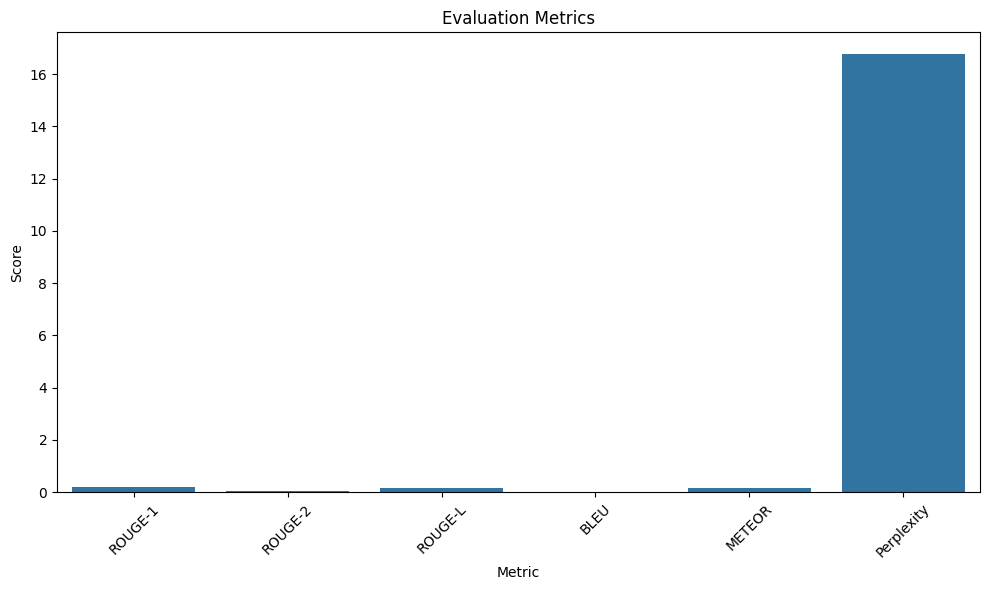

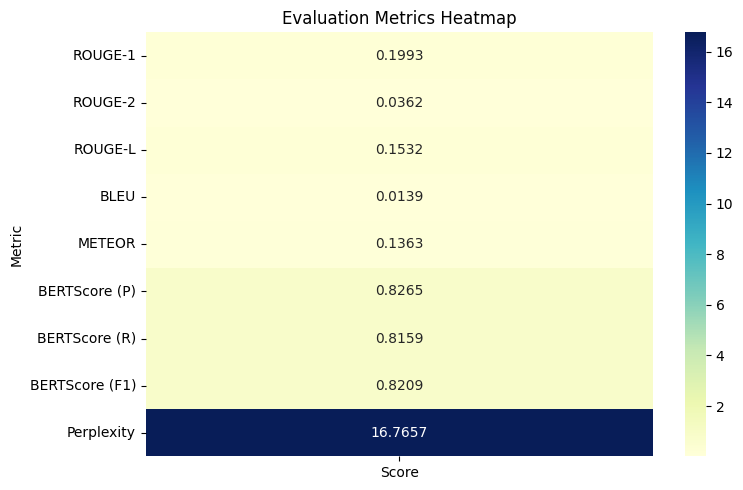

In [ ]:
# Step 21: Visualize Evaluation Metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the DataFrame for visualization (exclude BERTScore details if needed)
viz_df = df.copy()
viz_df = viz_df[~viz_df["Metric"].str.contains("BERTScore")]  # Remove BERTScore precision/recall/f1 for clarity

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=viz_df, x="Metric", y="Score")
plt.title("Evaluation Metrics")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Heatmap of all metrics
full_df = df.set_index("Metric")
plt.figure(figsize=(8, 5))
sns.heatmap(full_df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Evaluation Metrics Heatmap")
plt.tight_layout()
plt.show()